[2.03384161 4.77649234]


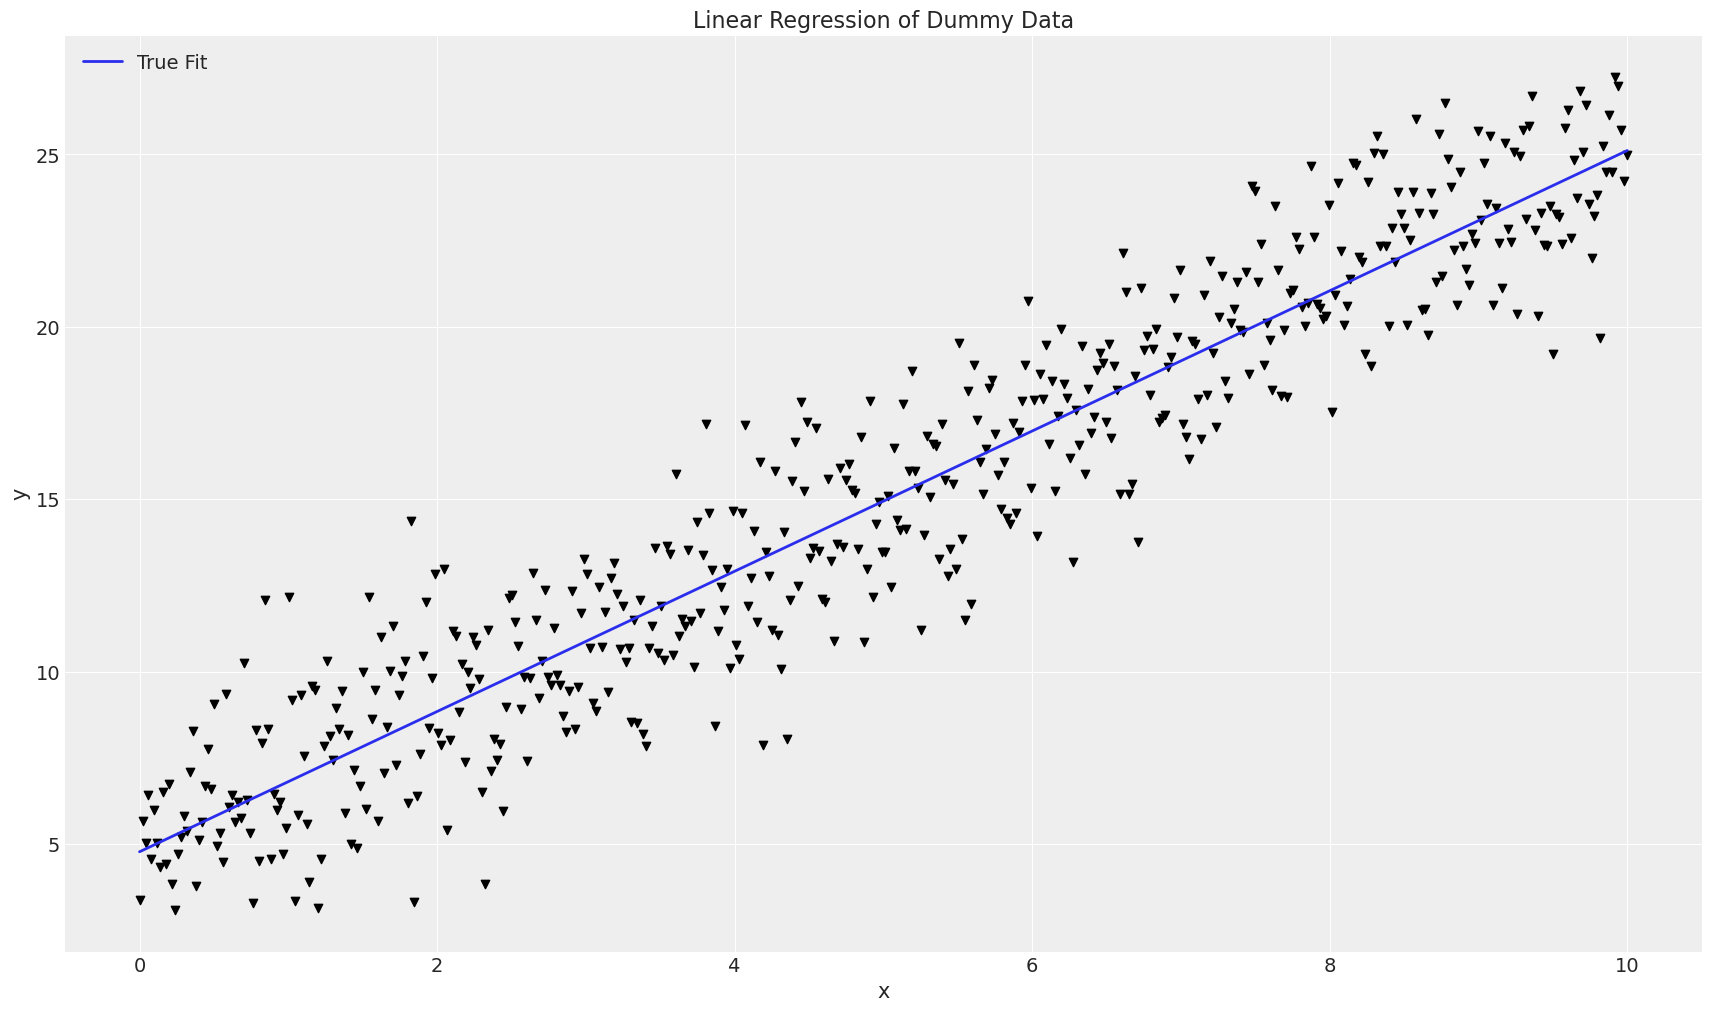

In [90]:
import pymc3 as pm
import numpy as np
np.random.seed(1000)
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pandas as pd


x = np.linspace(0, 10, 500)
sigma = np.random.standard_normal(len(x))* 2 
y = 5 +  2* x + sigma 

reg = np.polyfit(x, y, 1)  #TODO: Add weights 
print(reg)
plt.figure(figsize=(17, 10))
plt.scatter(x, y, c='black', marker='v')
plt.title(label='Linear Regression of Dummy Data')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0, label='True Fit')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()



C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\sbezo\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


C:\Users\sbezo\AppData\Local\Temp\ipykernel_6204\3596402474.py:10: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(100, step, start=start, progressbar=False)
C:\Users\sbezo\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, $β_1$, $β_0$]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 141 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\sbezo\AppData\Local\Temp\ipykernel_6204\3596402474.py:12: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for 

{'$β_0$': 4.683868557256157, '$β_1$': 2.0765524234746247, '$\\sigma$_log__': 0.6279852079050235, '$\\sigma$': 1.8738313927278085}


C:\Users\sbezo\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:214: UserWarning: A valid var_name should be provided, found {'b', 'a', 's'} expected from {'$\\sigma$', '$β_0$', '$β_1$'}
  warnings.warn(


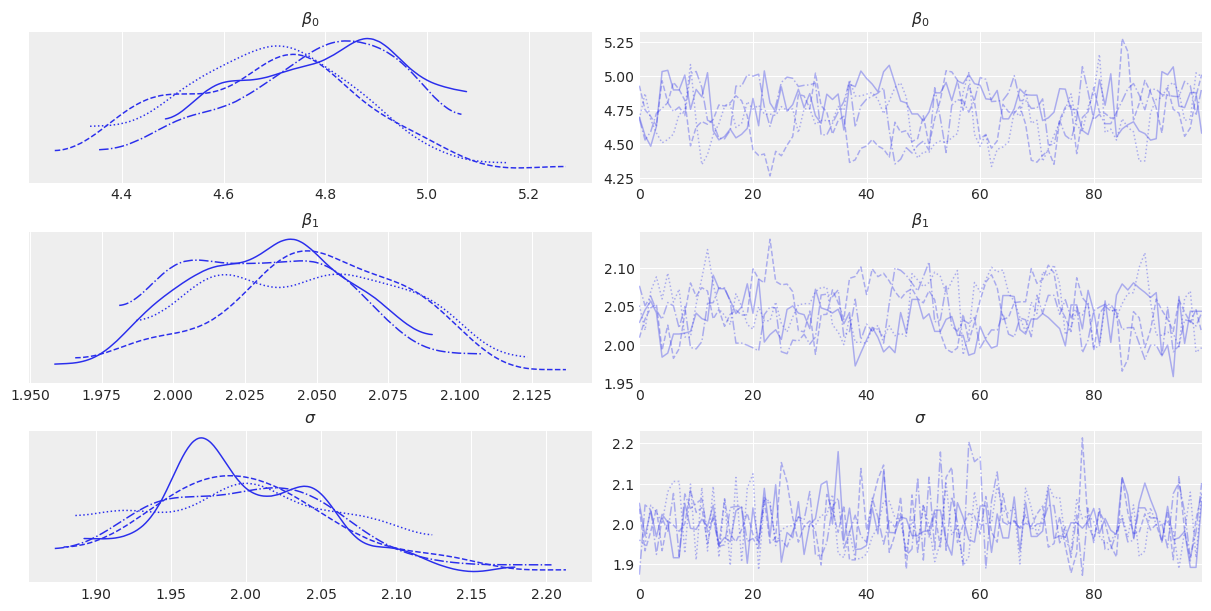

<Figure size 800x1000 with 0 Axes>

In [80]:
 with pm.Model() as model:
        
    beta_0 = pm.Normal('$β_0$', mu=0, sd=20)
    beta_1 = pm.Normal('$β_1$', mu=0, sd=20)
    sigma = pm.InverseGamma('$\sigma$',alpha=11, beta=15) #mean= 1.5 varience = .5^2
    y_est =  beta_0 + beta_1 * x
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(100, step, start=start, progressbar=False)
    print(trace[0])
    fig = pm.traceplot(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2})
    plt.figure(figsize=(8, 10))
    plt.show()
    

In [81]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\sbezo\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$β_0$,4.737,0.180,4.415,5.038,0.021,0.015,78.0,190.0,1.05
$β_1$,2.041,0.032,1.985,2.095,0.003,0.002,109.0,234.0,1.04
$\sigma$,2.002,0.062,1.895,2.116,0.003,0.002,592.0,211.0,1.00


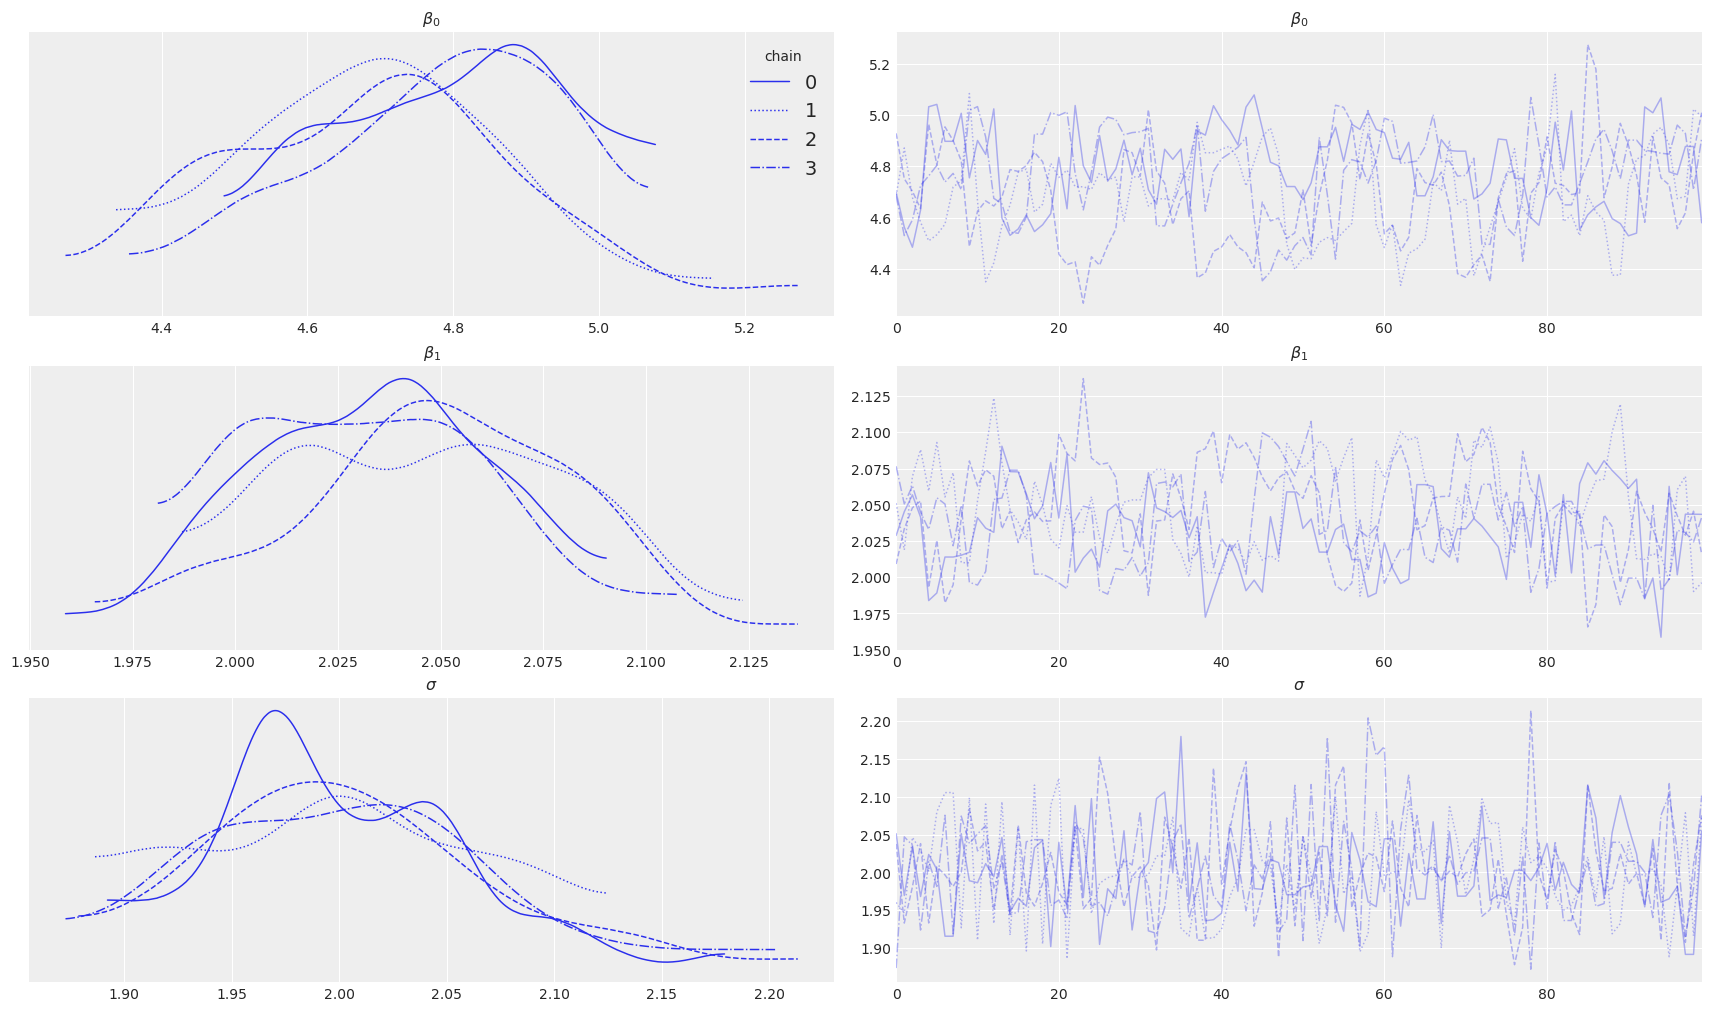

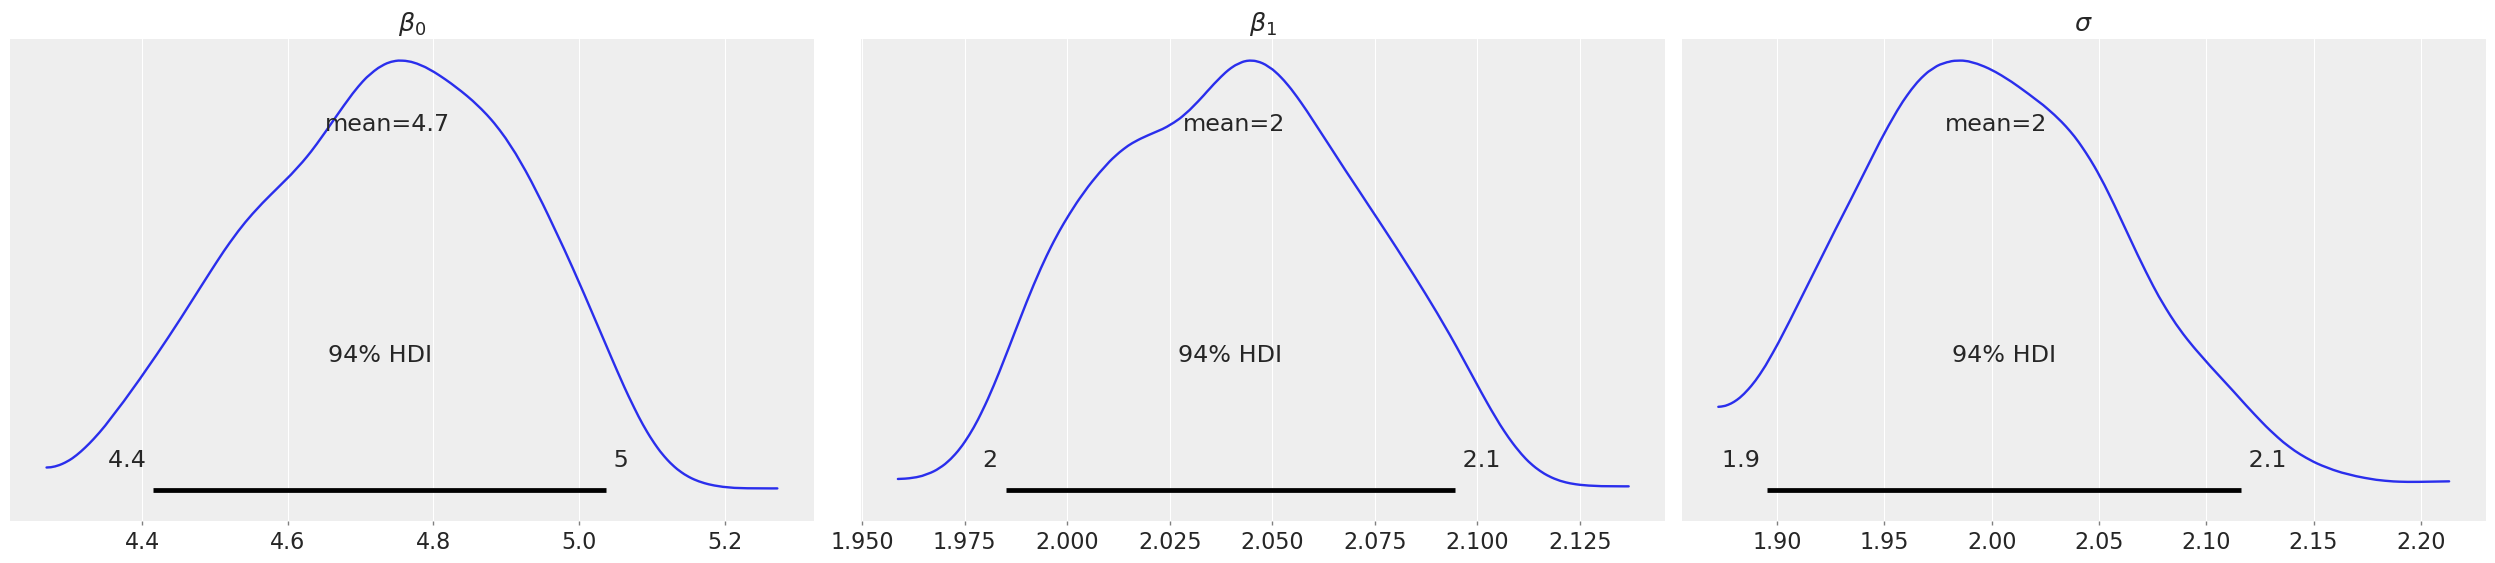

In [82]:
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42, progressbar=True)


with model: 
    trace_updated = az.from_pymc3(trace, posterior_predictive=ppc)
    
az.style.use("arviz-darkgrid")
with model:
  az.plot_trace(trace_updated, figsize=(17,10), legend=True)


az.style.use("arviz-darkgrid")
with model:
  az.plot_posterior(trace_updated,textsize=16)

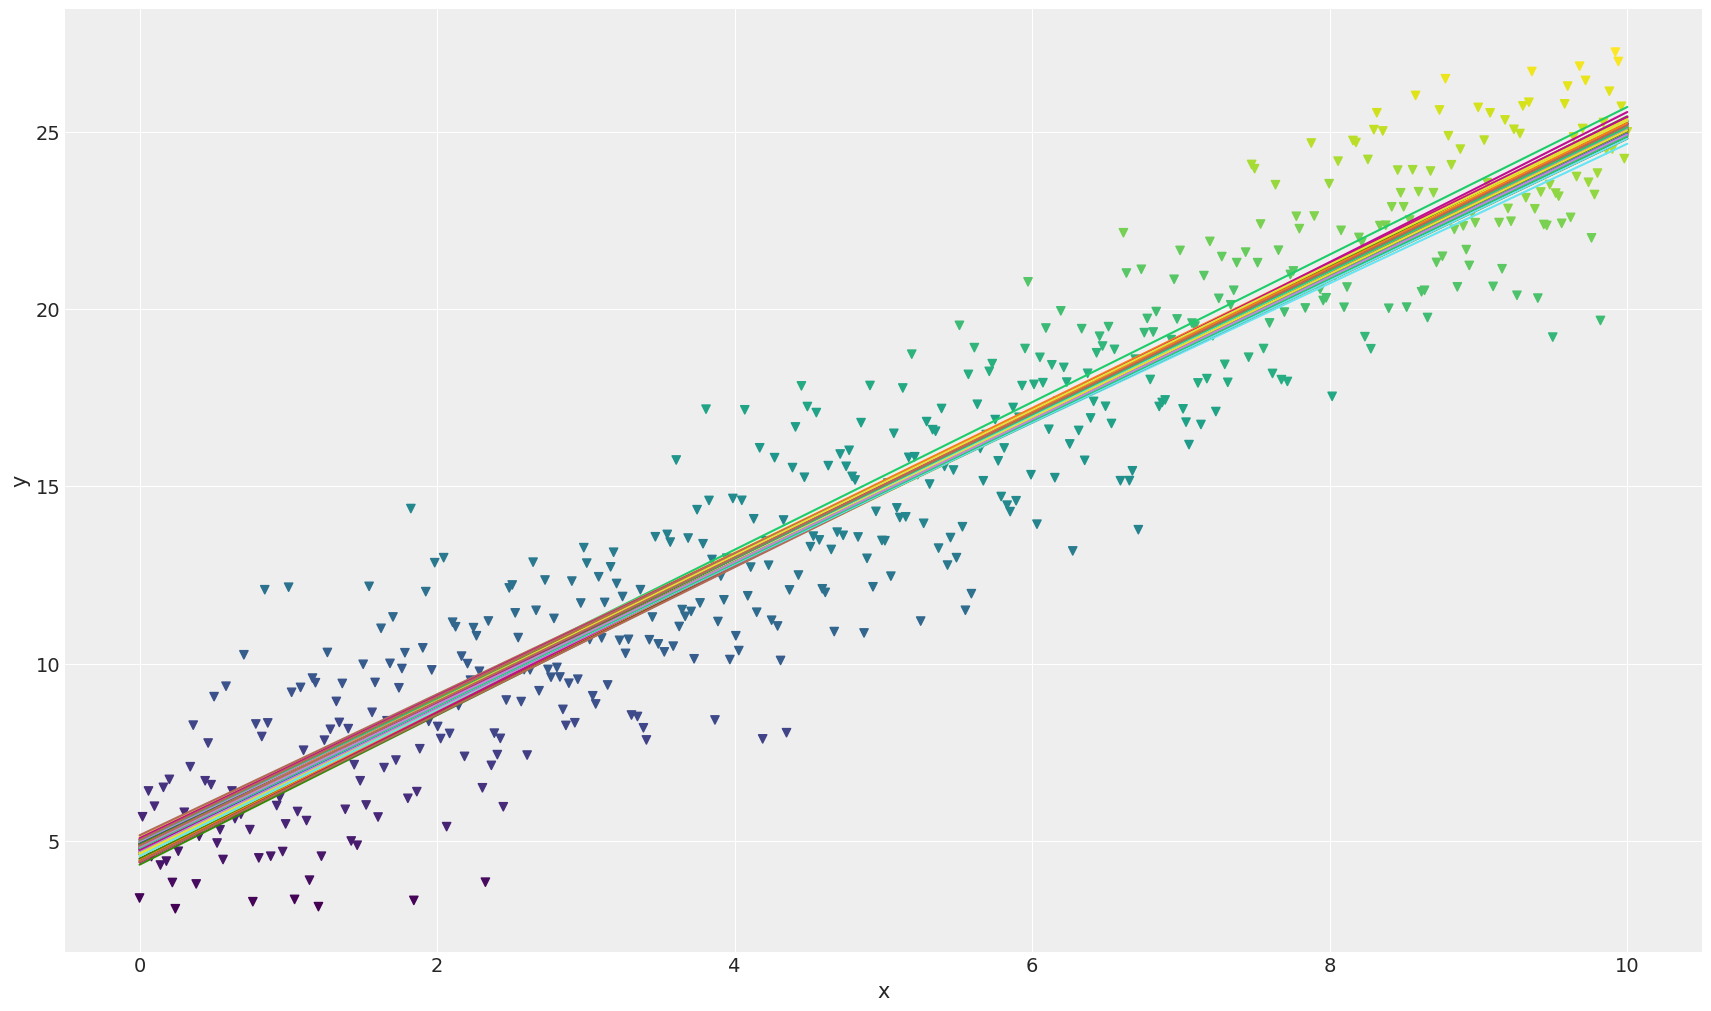

In [5]:
plt.figure(figsize=(17,10))
plt.scatter(x, y, c='black', marker='v')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

for i in range(len(trace)): 
    plt.plot(x, trace['beta_0'][i] + trace['beta_1'][i] * x) #TODO: Add uncertainity band, add credibility level, make color code meaningful

plt.show()

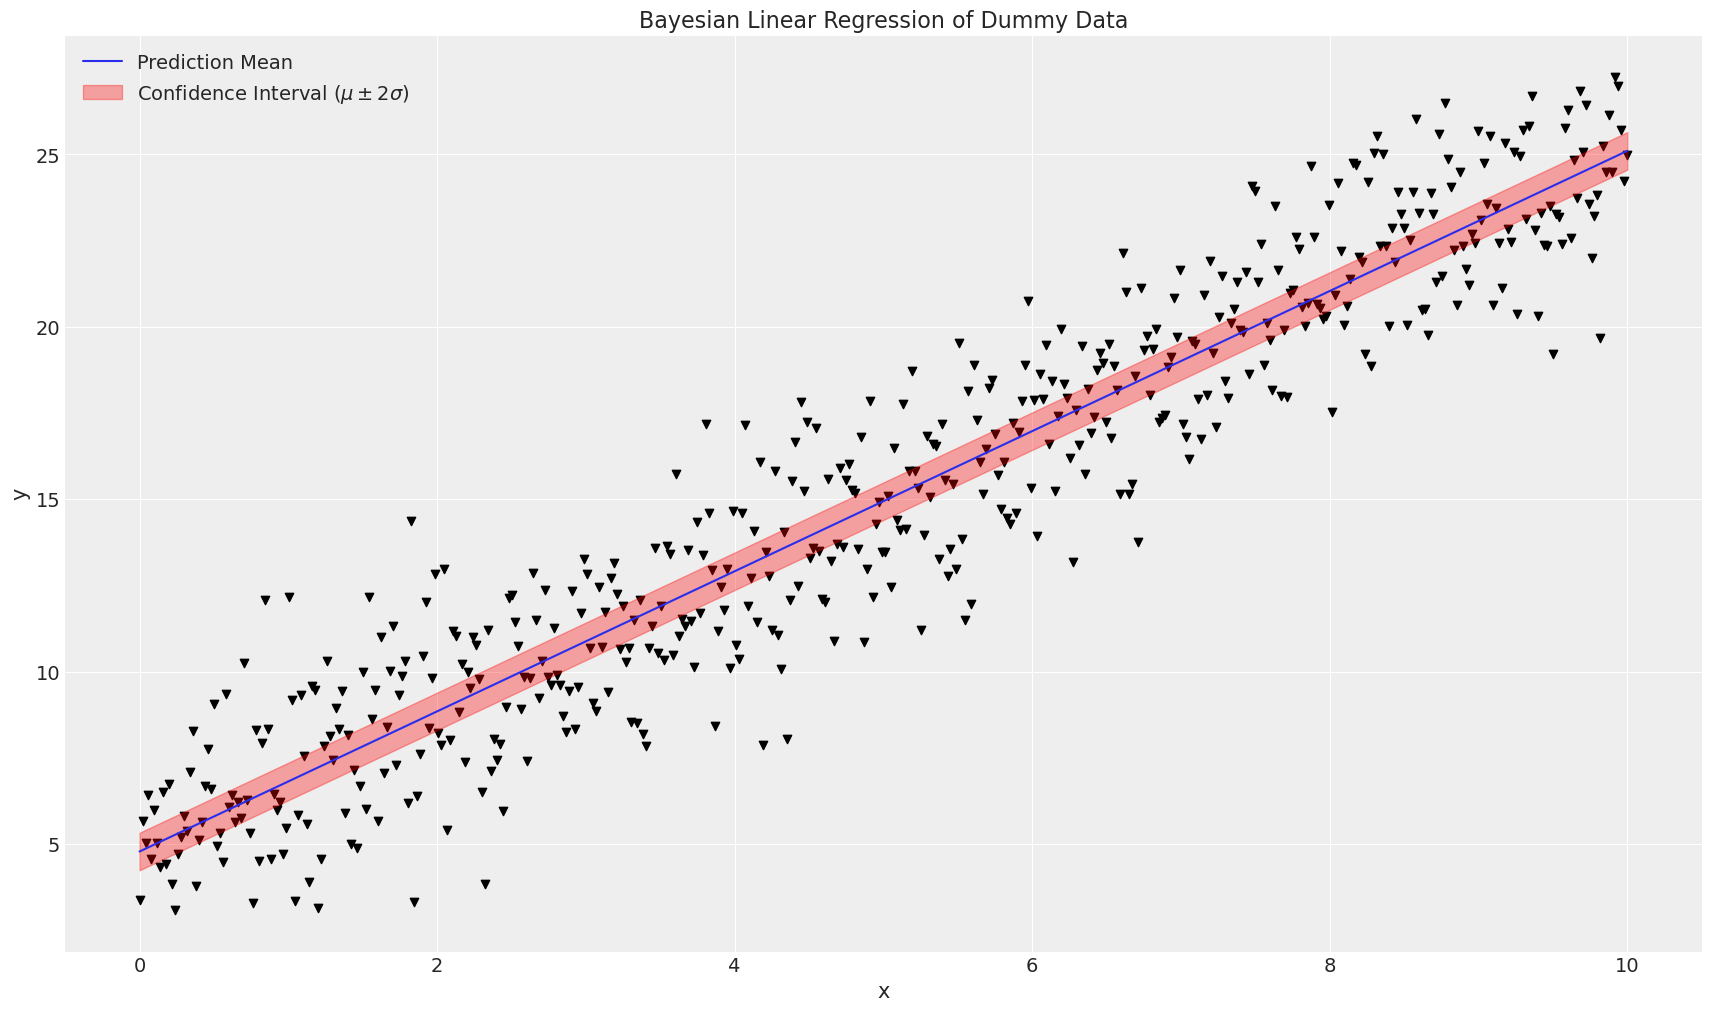

In [91]:
Z_0 = 1.96
beta_0_mean = 4.784
beta_0_std = 0.182
beta_1_mean = 2.032
beta_1_std = 0.031

#x_new = np.linspace(0, 10, 100)
y_average = beta_0_mean + beta_1_mean * x

def confidence_interval(mean, std, Z, number_of_samples):
    upper = mean + Z * (std / (number_of_samples)**(1/2))
    lower = mean - Z * (std / (number_of_samples)**(1/2))
    return lower,upper

beta_0_ci = confidence_interval(beta_0_mean, beta_0_std, Z_0, 500)
beta_1_ci = confidence_interval(beta_1_mean, beta_1_std, Z_0, 500)
    
y_min = beta_0_ci[0] + beta_1_ci[0] * x 
y_max = beta_0_ci[1] + beta_1_ci[1] * x  

plt.figure(figsize=(17,10))
plt.scatter(x, y, c='black', marker='v')
plt.grid(True)
plt.title(label = 'Bayesian Linear Regression of Dummy Data')
plt.xlabel('x')
plt.ylabel('y')  
plt.plot(x, y_average, label='Prediction Mean')
plt.legend()
plt.fill_between(x, y_average - 1.96*np.std(y)/(500)**(1/2), y_average + 1.96*np.std(y)/(500)**(1/2), \
                 color='r', alpha=.33, label= 'Confidence Interval ($\mu\pm2\sigma$)')
plt.legend(loc='upper left')
plt.savefig("BayesianLinRegDummy.png")